# CycleGAN

Implementation of the cyle GAN paper on vangough to photo dataset. Original Paper :- https://arxiv.org/abs/1703.10593

We have taken the vangogh to photos dataset and created an extended version of it by adding rotations as well as crops/ zoom to artworks of vangough helper functions defined in the model below.

The dataset is present in `data/vangogh2photo.zip`

In [5]:
import tensorflow as tf
from tensorflow.keras.layers import Input, BatchNormalization, LeakyReLU, Conv2D, Conv2DTranspose, Add
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers.legacy import Adam

from tqdm.notebook import tqdm
import numpy as np
import os

from matplotlib import pyplot as plt

import imageio.v3 as iio
from skimage.io import imsave

from helper_functions import clipped_zoom, plot_images

## Set Backend Device

In [6]:
if tf.test.gpu_device_name():
    print(f'Default GPU Device: {tf.test.gpu_device_name()}')

# Set the float pricision to 32bits to reduce memory usage
tf.keras.backend.set_floatx('float32')

# Stop the default logging output
tf.keras.utils.disable_interactive_logging()

Default GPU Device: /device:GPU:0


2023-09-18 16:39:26.078098: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-09-18 16:39:26.078119: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2023-09-18 16:39:26.078168: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-09-18 16:39:26.078176: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [7]:
BATCH_SIZE = 12
EPOCHS = 75

## Setup data

In [8]:
# Unzip the data for training
if not os.path.exists("data/vangogh2photo"):
    os.system("unzip -qq data/vangogh2photo.zip -d data/")

## Model

In [5]:
class Cycle_GAN:
    def __init__(self, batch_size, epochs, base_dir, trainA, trainB):
        """
            params:
            -------
                * batch_size : size of an individual batch
                * epochs : number of epochs to train on
                * base_dir : base directory containing sub dictories of two samples
                * trainA : path inside base directory containing class A (vangogh artworks)
                * trainB : path inside base directory containing class B (standard images)
        """
        self.base_dir = base_dir
        self.trainA_path = self.base_dir + trainA
        self.trainB_path = self.base_dir + trainB
        self.batch_size = batch_size
        self.img_shape = (256, 256, 3)
        self.epochs = epochs

        if self.trainA_path[-1]!="/":
            self.trainA_path += "/"
        
        if self.trainB_path[-1]!="/":
            self.trainB_path += "/"

        # Weightage to cycle consistency loss
        self.cycle_loss = 12.0
        
        # Id loss : Add loss for identity mapping as mentioned in the section 5.2 of the paper to improve the convergence
        # and improve the images generated
        self.id_loss = 3.0
        
        ######################################
        #   Define the Computational Graph   #
        ######################################

        img_1 = Input(shape=self.img_shape)
        img_2 = Input(shape=self.img_shape)
        
        # Create the discriminators & Compile
        self.disc1 = self.__build_discriminator(img_1, "discrim_1")
        self.disc2 = self.__build_discriminator(img_2, "discrim_2")
        self.disc1.compile(loss = "mse", optimizer = Adam(0.0003, 0.6))
        self.disc2.compile(loss = "mse", optimizer = Adam(0.0003, 0.6))

        self.disc1.trainable = False
        self.disc2.trainable = False

        # Create the Generators
        self.gen_XY = self.__build_generator(img_1, "gen_1")
        self.gen_YX = self.__build_generator(img_2, "gen_2")

        ####################
        #  Combined Model  #
        ####################

        fakeY = self.gen_XY(img_1)
        fakeX = self.gen_YX(img_2)

        # reconstruct back original from fake
        reconst_X = self.gen_YX(fakeY)
        reconst_Y = self.gen_XY(fakeX)

        # forward to the discriminators
        d_out1 = self.disc1(fakeX)
        d_out2 = self.disc1(fakeY)

        # identity mapping of images
        X_id = self.gen_YX(img_1)
        Y_id = self.gen_XY(img_2)

        # combined model compiled
        self.combined = Model([img_1, img_2], [d_out1, d_out2, reconst_X, reconst_Y, X_id, Y_id], name="Combined")
        self.combined.compile(loss = ["mse", "mse", "mae", "mae", "mae", "mae"], optimizer = Adam(0.0003, 0.6), loss_weights=[ 1, 1, self.cycle_loss, self.cycle_loss, self.id_loss, self.id_loss])
        # self.combined.summary()

    def random_crops(self):
        """
            Helper function which generates additional images for better model training on the artworks of vangough
            by adding rotations and crops/ zoom.

            Data in saved in the directories :-
                * self.trainA_path + zoomed/
                * self.trainA_path + rotated/
        """
        A_samples = os.listdir(self.trainA_path)
        A_samples = [x for x in A_samples if (".jpg" in x or ".png" in x)]
        for file in A_samples:
            im = iio.imread(self.trainA_path+file)
            shape = im.shape
            # zoom/ crop
            choice = np.random.choice((1.25, 1.5, 1.75, 2.0))
            result = clipped_zoom(im, choice)
            path = self.trainA_path+f"zoomed/zoom_{file}"
            imsave(path, result)
            
            # Rotations
            path = self.trainA_path+f"rotated/rot90_{file}"
            
            # Rotate 90 image for now handle crop later
            im = np.rot90(im)
            imsave(path, im)

            # Rotate 270 image for now handle crop later
            path = self.trainA_path+f"rotated/rot270_{file}"
            im = np.rot90(np.rot90(im))
            imsave(path, im)
    
    def __load_data(self):
        """
            Helper function to return data in batches from the provided paths.
            Return a generator of batch images for generator A & B to help manage the memory usage.
        """
        A_samples = os.listdir(self.trainA_path)
        B_samples = os.listdir(self.trainB_path)
        A_samples = [x for x in A_samples if (".jpg" in x or ".png" in x)]
        B_samples = [x for x in B_samples if (".jpg" in x or ".png" in x)]
        np.random.shuffle(A_samples)
        np.random.shuffle(B_samples)
        
        all_files = tuple(zip(A_samples, B_samples))
        
        total_files = len(all_files)
        for ndx in range(0, total_files, self.batch_size):
            # data to be loaded
            A_imgs = []
            B_imgs = []
            batch = all_files[ndx:min(ndx + self.batch_size, total_files)]
            for file1, file2 in batch:
                # Read the file, add them to the arrays
                img1 = iio.imread(self.trainA_path+file1)
                img2 = iio.imread(self.trainB_path+file2)
                # Scale images in range 0-1
                A_imgs.append((img1/255).astype(np.float32))
                B_imgs.append((img2/255).astype(np.float32))
            yield np.array(A_imgs).astype(np.float32), np.array(B_imgs).astype(np.float32)
    
    def train(self,):
        # Define the patch size
        patch_size = (32, 32, 1)

        for epoch in tqdm(range(1, self.epochs + 1)):
            # d_losses = []
            # g_losses = []
            g_loss = None
            d_loss = None
            
            # For each epoch train the model
            for batch in self.__load_data():
                batchX, batchY = batch[0], batch[1]

                fakeY = self.gen_XY.predict(batchX)
                fakeX = self.gen_YX.predict(batchY)

                # Adversarial network labels
                _len = len(fakeX)
                real_labels = np.ones((_len,) + patch_size).astype(np.float32)
                fake_labels = np.zeros((_len,) + patch_size).astype(np.float32)

                # Create combined batch of fake and real
                imgsX = np.concatenate([batchX, fakeX]).astype(np.float32)
                imgsY = np.concatenate([batchY, fakeY]).astype(np.float32)
                
                # Define labels for images (real + fake) in a given batch
                labelsX = np.concatenate([real_labels, fake_labels]).astype(np.float32)
                labelsY = np.concatenate([real_labels, fake_labels]).astype(np.float32)
                
                # Shuffle
                indices = np.arange(len(imgsX))
                np.random.shuffle(indices)
                imgsX, imgsY = imgsX[indices], imgsY[indices]
                labelsX, labelsY = labelsX[indices], labelsY[indices]

                # Disciminators loss
                d_loss1 = self.disc1.train_on_batch(imgsX, labelsX)
                d_loss2 = self.disc2.train_on_batch(imgsY, labelsY)
                d_loss = (d_loss1, d_loss2)
                
                # Train the generators
                g_loss = self.combined.train_on_batch([batchX, batchY], [real_labels, real_labels, batchX, batchY, batchX, batchY])

            if (epoch % 12 == 0):
                print(f"############################## EPOCH : {epoch} ##############################")
                print(g_loss)
                generated_images, labels = self.generate_some_imgs(4)
                plot_images(2, 4, (10, 7), generated_images, labels, default_shape=(256, 256, 3))

    def generate_some_imgs(self, num = 4):
        """
            Helper function to generate some images from the generators of the model
            params:
            -------
                * num : number of images to generate
        """
        assert num % 2 == 0
        imgs = []
        labels = []

        A_samples = os.listdir(self.trainA_path)
        B_samples = os.listdir(self.trainB_path)
        A_samples = [x for x in A_samples if (".jpg" in x or ".png" in x)]
        B_samples = [x for x in B_samples if (".jpg" in x or ".png" in x)]
        np.random.shuffle(A_samples)
        np.random.shuffle(B_samples)

        all_files = tuple(zip(A_samples, B_samples))[:num]
        for file1, file2 in all_files:
            # Read the file, add them to the arrays
            img1 = (iio.imread(self.trainA_path+file1))/255
            img2 = (iio.imread(self.trainB_path+file2))/255
            
            imgs.append(img1)
            generated_img = self.gen_XY.predict(np.array([img1]))[0]
            # Scale to range 0-1
            generated_img = (generated_img + 1)/2
            imgs.append(generated_img)
            labels += ["Original X", "Translated X->Y"]

            imgs.append(img2)
            imgs.append(self.gen_YX.predict(np.array([img2]))[0])
            labels += ["Original Y", "Translated Y->X"]
        return imgs, labels
    
    def __get_conv_layer(self, inp, filters, k_size: tuple, strides = 1):
        """
            Helper function defining a standard convolution operation with batch norm and activation function
        """
        x = Conv2D(filters = filters, kernel_size=k_size, padding='same', strides = strides)(inp)
        x = BatchNormalization(momentum = 0.5)(x)
        return LeakyReLU(0.3)(x)
    
    def __get_residual_block(self, inp, num_blocks, filters, k_size:tuple):
        """
            Helper function to create residual blocks
        """
        # Define internal function for a single block
        def build_residual_block(inp, filters, k_size, layer_name = None):
            x = Conv2D(filters = filters, kernel_size=k_size, padding='same', name=layer_name)(inp)
            x = LeakyReLU(0.3)(BatchNormalization(momentum = 0.5)(x))
            x = Conv2D(filters = filters, kernel_size=k_size, padding='same')(x)
            x = BatchNormalization(momentum = 0.5)(x)
            return Add()([x, inp])

        x = build_residual_block(inp, filters, k_size, layer_name = "residual_1")
        num_blocks -= 1
        for i in range(num_blocks):
            x = build_residual_block(x, filters, k_size, layer_name = f"residual_{i+2}")
        return x

    def __build_generator(self, inp, name = None):
        """
            Helper function to build generator
        """
        # Auto encoder based approach
        x = self.__get_conv_layer(inp, 64, (7,7), 1)
        x = self.__get_conv_layer(x, 128, (3,3), 2)
        x = self.__get_conv_layer(x, 256, (3,3), 2)
        x = self.__get_residual_block(x, 7, 256, (3,3))

        # Upsample
        x = Conv2DTranspose(filters = 128, kernel_size=(3,3), strides = 2, activation=LeakyReLU(alpha=0.3), padding="same")(x)
        x = Conv2DTranspose(filters = 64, kernel_size=(3,3), strides = 2, activation=LeakyReLU(alpha=0.3), padding="same")(x)
        x = Conv2D(filters = 3, kernel_size=(7,7), padding='same', activation = 'tanh')(x)
        return Model(inp, x, name=name)
    
    def __build_discriminator(self, inp, name = None):
        """
            Returns a patch style discriminiator Model
        """
        # Patch GAN style discriminator
        x = self.__get_conv_layer(inp, 64, (4,4), 2)
        x = self.__get_conv_layer(x, 128, (4,4), 2)
        x = self.__get_conv_layer(x, 256, (4,4), 2)
        x = self.__get_conv_layer(x, 512, (4,4), 1)
        x = self.__get_conv_layer(x, 1, (4,4), 1)
        return Model(inp, x, name=name)

In [6]:
obj = Cycle_GAN(BATCH_SIZE, EPOCHS, "./data/vangogh2photo/", "trainA", "trainB")

  0%|          | 0/75 [00:00<?, ?it/s]

############################## EPOCH : 12 ##############################
[2.1325864791870117, 0.09799730777740479, 0.05301641672849655, 0.07097495347261429, 0.06185179576277733, 0.07141691446304321, 0.05780038237571716]


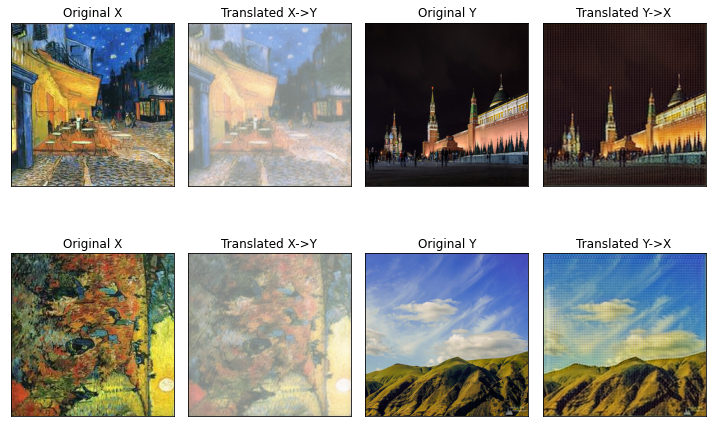

############################## EPOCH : 24 ##############################
[2.10573410987854, 0.005811735056340694, 0.02350202202796936, 0.07811779528856277, 0.05757959187030792, 0.09743724763393402, 0.05191335454583168]


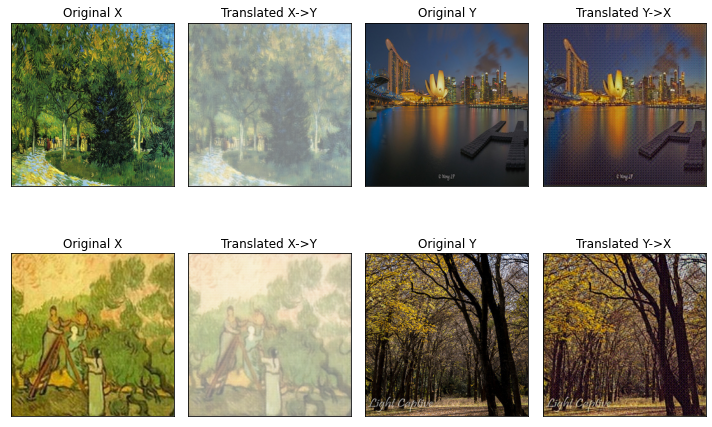

############################## EPOCH : 36 ##############################
[2.193976640701294, 0.016185330227017403, 0.017150847241282463, 0.08830471336841583, 0.05922052264213562, 0.0836135745048523, 0.04649895429611206]


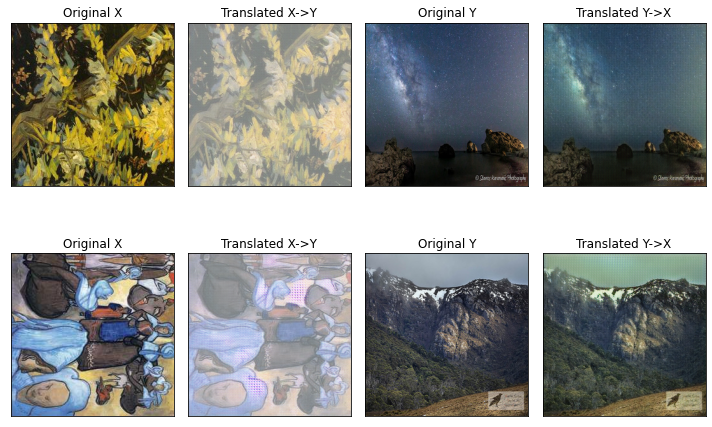

############################## EPOCH : 48 ##############################
[1.8685349225997925, 0.006000177934765816, 0.0008934469660744071, 0.06715164333581924, 0.056645870208740234, 0.0685986578464508, 0.05675836652517319]


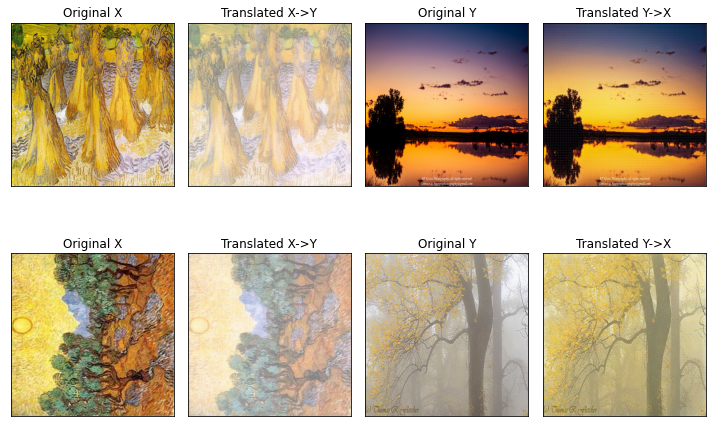

############################## EPOCH : 60 ##############################
[1.2139430046081543, 0.0068550389260053635, 0.0014355869498103857, 0.029144730418920517, 0.052735745906829834, 0.026554523035883904, 0.0478077195584774]


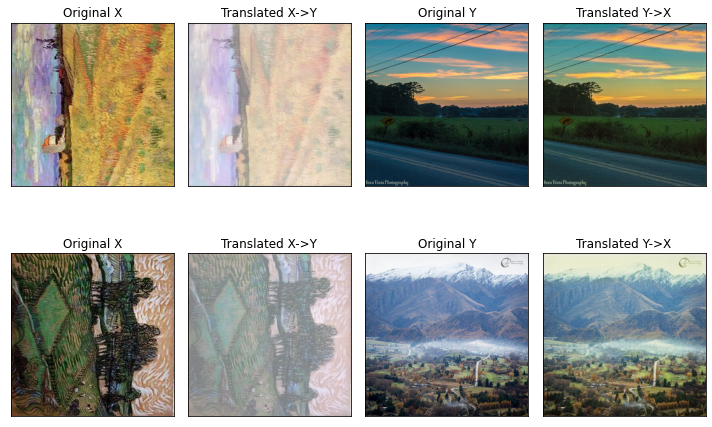

############################## EPOCH : 72 ##############################
[0.9537664651870728, 0.013680273666977882, 0.002248144242912531, 0.020325563848018646, 0.04221852496266365, 0.017750855535268784, 0.04468546435236931]


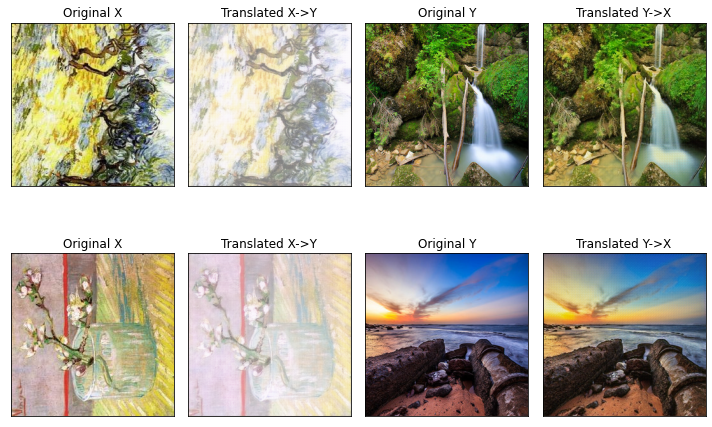

In [7]:
# Train the model
obj.train()

## Show some Traslated Examples

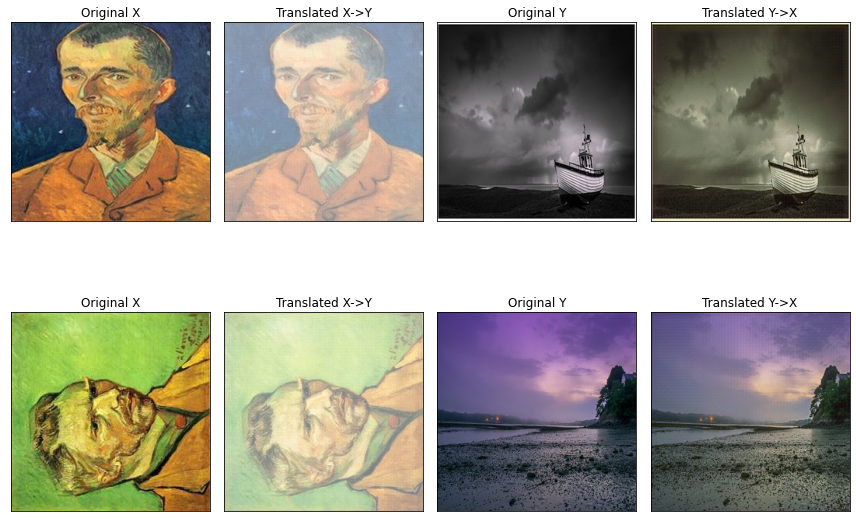

In [9]:
generated_images, labels = obj.generate_some_imgs(4)
plot_images(2, 4, (12, 9), generated_images, labels, default_shape=(256, 256, 3))

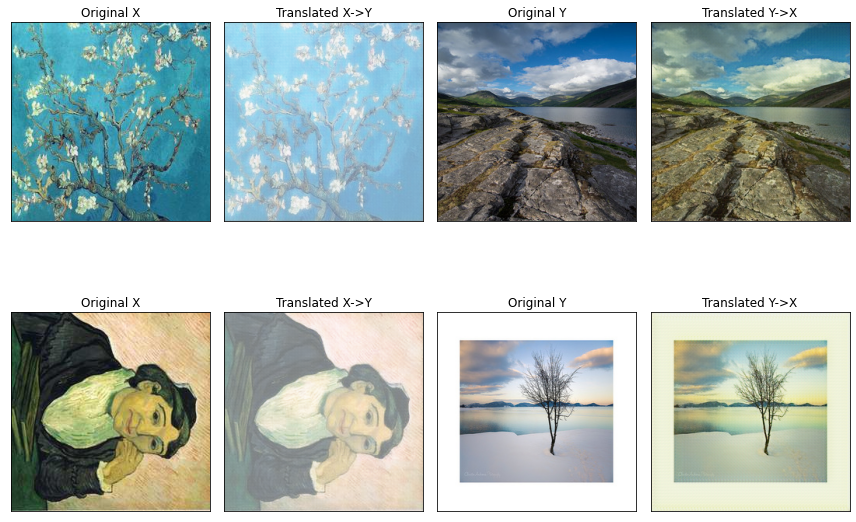

In [11]:
generated_images, labels = obj.generate_some_imgs(4)
plot_images(2, 4, (12, 9), generated_images, labels, default_shape=(256, 256, 3))

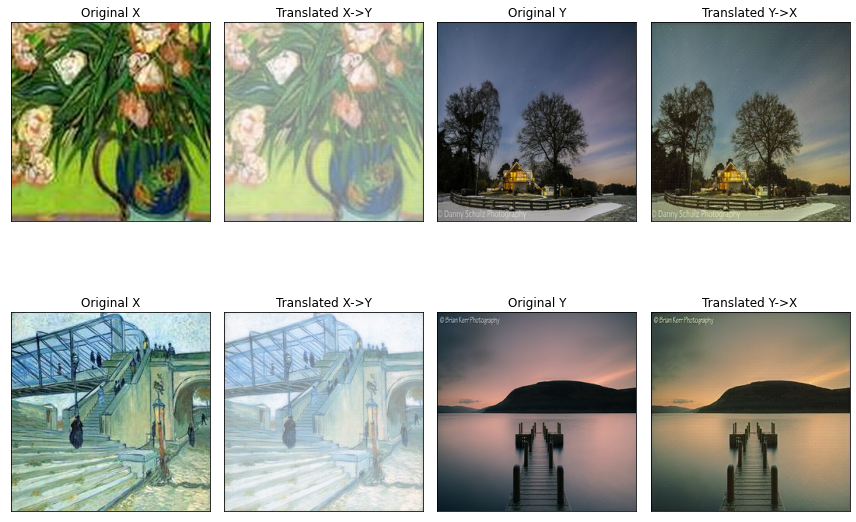

In [38]:
generated_images, labels = obj.generate_some_imgs(4)
plot_images(2, 4, (12, 9), generated_images, labels, default_shape=(256, 256, 3))